In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.
print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile']


In [4]:
print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile']


In [5]:
from cosmodc2.sdss_colors import mock_magr

mock['restframe_extincted_sdss_abs_magr'] = mock_magr(
            mock['upid'], mock['obs_sm'], mock['sfr_percentile'], 
            mock['host_halo_mvir'], sdss['sm'], sdss['sfr_percentile_fixed_sm'], 
            sdss['restframe_extincted_sdss_abs_magr'], sdss['z'])


In [6]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

magr = mock['restframe_extincted_sdss_abs_magr'] 
percentile = mock['sfr_percentile']
redshift = np.zeros_like(magr)

gr, ri, is_red_ri, is_red_gr = gr_ri_monte_carlo(
    magr, percentile, redshift, local_random_scale=0.1)

mock['restframe_extincted_sdss_gr'] = gr
mock['restframe_extincted_sdss_ri'] = ri
mock['is_red_gr'] = is_red_gr
mock['is_red_ri'] = is_red_ri


from cosmodc2.sdss_colors import remap_cluster_bcg_gr_ri_color
_result = remap_cluster_bcg_gr_ri_color(
        mock['upid'], mock['host_halo_mvir'], 
        np.copy(mock['restframe_extincted_sdss_gr']), 
        np.copy(mock['restframe_extincted_sdss_ri']), 
        mock['is_red_gr'], mock['is_red_ri'])
gr_remapped, ri_remapped, is_red_gr_remapped, is_red_ri_remapped = _result

mock['_gr_no_remap'] = np.copy(mock['restframe_extincted_sdss_gr'])
mock['_ri_no_remap'] = np.copy(mock['restframe_extincted_sdss_ri'])
mock['restframe_extincted_sdss_gr'] = gr_remapped
mock['restframe_extincted_sdss_ri'] = ri_remapped
mock['_is_red_ri_no_remap'] = np.copy(is_red_ri)
mock['_is_red_gr_no_remap'] = np.copy(is_red_gr)
mock['is_red_gr'] = is_red_gr_remapped
mock['is_red_ri'] = is_red_ri_remapped


## Develop remapping probability function

In [59]:
from cosmodc2.sdss_colors.fix_cluster_lf import cluster_bcg_red_sequence_gr_ri
from halotools.empirical_models import conditional_abunmatch

def remap_satellites(mstar, gr, ri, 
                     gr_red_sequence_median, ri_red_sequence_median, 
                     gr_red_sequence_scatter, ri_red_sequence_scatter,
                    nwin=301):
    """
    """
    num_to_remap = len(mstar)
    bcg_red_sequence_gr, bcg_red_sequence_ri = cluster_bcg_red_sequence_gr_ri(
        num_to_remap, gr_red_sequence_median,
        ri_red_sequence_median, gr_red_sequence_scatter)

    input_gr = gr
    desired_gr = bcg_red_sequence_gr
    output_gr = conditional_abunmatch(
        mstar, input_gr, mstar, desired_gr, nwin)

    desired_ri = bcg_red_sequence_ri
    noisy_input_gr = np.random.normal(loc=output_gr, scale=0.1)
    output_ri = conditional_abunmatch(
        mstar, noisy_input_gr, mstar, desired_ri, nwin)
    return output_gr, output_ri

In [96]:
# x1=(9, 9.75, 10.25, 11), y1=(1., 1., 1., 1.),
#             x2=(13.75, 14, 14.5), y2=(0.0, 0.3, 0.5)
    
def prob_remap_cluster_satellite(upid, mstar, host_halo_mvir,
            x1=(9, 9.75, 10.25, 11), y1=(1., 1., 1., 1.),
            x2=(13.5, 14, 14.5), y2=(0.0, 0.5, 0.75)):
    """
    """
    ngals = len(mstar)
    satmask = upid != -1
    mstar_prob = np.interp(np.log10(mstar), x1, y1)
    mhost_prob = np.interp(np.log10(host_halo_mvir), x2, y2)
    mstar_mask = np.random.rand(ngals) < mstar_prob
    mhost_mask = np.random.rand(ngals) < mhost_prob
    remapping_mask = mstar_mask & mhost_mask & satmask
    return remapping_mask


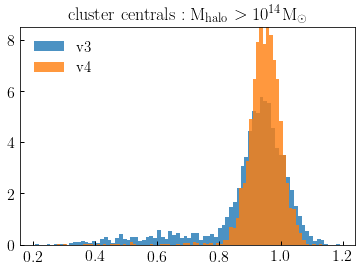

In [113]:
from cosmodc2.sdss_colors.analytical_colors import red_sequence_peak_gr, red_sequence_peak_ri
from cosmodc2.sdss_colors.analytical_colors import red_sequence_width_gr, red_sequence_width_ri


remapping_mask = prob_remap_cluster_satellite(mock['upid'], mock['obs_sm'],
                        mock['host_halo_mvir'])

gr_peak = red_sequence_peak_gr(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
ri_peak = red_sequence_peak_ri(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
gr_scatter = 0.04
ri_scatter = 0.03

mstar = mock['obs_sm'][remapping_mask]
gr = mock['restframe_extincted_sdss_gr'][remapping_mask]
ri = mock['restframe_extincted_sdss_ri'][remapping_mask]
new_gr, new_ri = remap_satellites(mstar, gr, ri, gr_peak, ri_peak, gr_scatter, ri_scatter)

mock['modified_gr'] = np.copy(mock['restframe_extincted_sdss_gr'])
mock['modified_gr'][remapping_mask] = new_gr
mock['modified_ri'] = np.copy(mock['restframe_extincted_sdss_ri'])
mock['modified_ri'][remapping_mask] = new_ri

magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -19
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14
mw_halo_mask = (mock['host_halo_mvir'] > 10**12) & (mock['host_halo_mvir'] < 10**12.5)


fig, ax = plt.subplots(1, 1)

nbins = 80
# __=ax.hist(mock['restframe_extincted_sdss_gr'][~cenmask & mw_halo_mask & magr_mask], 
#                bins=nbins, normed=True, alpha=0.8, 
#               label=r'$z=0\ {\rm Milky\ Way\ satellites}$')

__=ax.hist(mock['_gr_no_remap'][cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v3}$')

__=ax.hist(mock['modified_gr'][cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v4}$')

title = ax.set_title(r'${\rm cluster\ centrals: M_{halo} > 10^{14}M_{\odot}}$')
# __=ax.hist(mock['modified_gr'][~cenmask & mw_halo_mask & magr_mask], 
#                bins=nbins, normed=True, alpha=0.8, 
#               label=r'$z=0\ {\rm Milky\ Way\ satellites}$')

legend = ax.legend()

ylim = ax.set_ylim(0, 8.5)
figname = 'mw_vs_cluster_central_gr_distribution_v3_vs_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

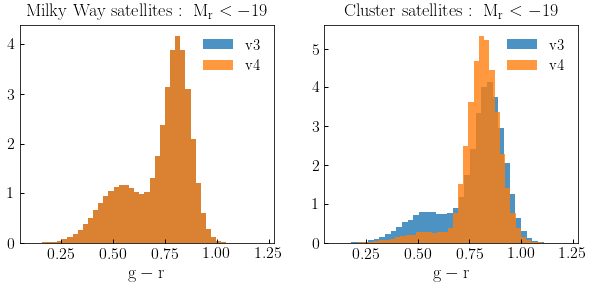

In [112]:
from cosmodc2.sdss_colors.analytical_colors import red_sequence_peak_gr, red_sequence_peak_ri
from cosmodc2.sdss_colors.analytical_colors import red_sequence_width_gr, red_sequence_width_ri


remapping_mask = prob_remap_cluster_satellite(mock['upid'], mock['obs_sm'],
                        mock['host_halo_mvir'])

gr_peak = red_sequence_peak_gr(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
ri_peak = red_sequence_peak_ri(mock['restframe_extincted_sdss_abs_magr'][remapping_mask])
gr_scatter = 0.04
ri_scatter = 0.03

mstar = mock['obs_sm'][remapping_mask]
gr = mock['restframe_extincted_sdss_gr'][remapping_mask]
ri = mock['restframe_extincted_sdss_ri'][remapping_mask]
new_gr, new_ri = remap_satellites(mstar, gr, ri, gr_peak, ri_peak, gr_scatter, ri_scatter)

mock['modified_gr'] = np.copy(mock['restframe_extincted_sdss_gr'])
mock['modified_gr'][remapping_mask] = new_gr
mock['modified_ri'] = np.copy(mock['restframe_extincted_sdss_ri'])
mock['modified_ri'][remapping_mask] = new_ri

magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -19
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14
group_halo_mask = (mock['host_halo_mvir'] > 10**13) & (mock['host_halo_mvir'] < 10**13.5)
mw_halo_mask = (mock['host_halo_mvir'] > 10**12) & (mock['host_halo_mvir'] < 10**12.5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

nbins = 40
__=ax1.hist(mock['restframe_extincted_sdss_gr'][~cenmask & mw_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v3}$')

__=ax1.hist(mock['modified_gr'][~cenmask & mw_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v4}$')

__=ax2.hist(mock['restframe_extincted_sdss_gr'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v3}$')

__=ax2.hist(mock['modified_gr'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm v4}$')


legend = ax1.legend()
legend2 = ax2.legend()
xlabel1 = ax1.set_xlabel(r'${\rm g-r}$')
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
title1 = ax1.set_title(r'${\rm Milky\ Way\ satellites:\ M_{r} < -19}$')
title2 = ax2.set_title(r'${\rm Cluster\ satellites:\ M_{r} < -19}$')

figname = 'mw_vs_cluster_satellite_gr_distribution_v3_vs_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

In [69]:
from cosmodc2.sdss_colors import zehavi11_clustering
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi

wp_blue18p5, wperr_blue18p5 = zehavi11_clustering(-18.5, subsample='blue')
wp_red18p5, wperr_red18p5 = zehavi11_clustering(-18.5, subsample='red')

wp_blue19p0, wperr_blue19p0 = zehavi11_clustering(-19, subsample='blue')
wp_red19p0, wperr_red19p0 = zehavi11_clustering(-19, subsample='red')

wp_blue19p5, wperr_blue19p5 = zehavi11_clustering(-19.5, subsample='blue')
wp_red19p5, wperr_red19p5 = zehavi11_clustering(-19.5, subsample='red')

wp_blue20p0, wperr_blue20p0 = zehavi11_clustering(-20, subsample='blue')
wp_red20p0, wperr_red20p0 = zehavi11_clustering(-20, subsample='red')

wp_blue20p5, wperr_blue20p5 = zehavi11_clustering(-20.5, subsample='blue')
wp_red20p5, wperr_red20p5 = zehavi11_clustering(-20.5, subsample='red')

wp_blue21p5, wperr_blue21p5 = zehavi11_clustering(-21.5, subsample='blue')
wp_red21p5, wperr_red21p5 = zehavi11_clustering(-21.5, subsample='red')


In [70]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

# rp_mids, wp_v4_18p5_blue = zehavi_wp(x, y, z, vz, 
#             period, magr, -18.5, protoDC2_littleh, 
#             subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

# rp_mids, wp_v4_18p5_red = zehavi_wp(x, y, z, vz, 
#             period, magr, -18.5, protoDC2_littleh, 
#             subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

...calculating wp for 4.00e+05 galaxies and Mr < -19.0
...calculating wp for 4.01e+05 galaxies and Mr < -19.0
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 1.68e+05 galaxies and Mr < -20.5
...calculating wp for 2.50e+05 galaxies and Mr < -20.5
...calculating wp for 9.49e+03 galaxies and Mr < -21.5
...calculating wp for 3.71e+04 galaxies and Mr < -21.5


In [71]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

# rp_mids, wp_v4_18p5_blue = zehavi_wp(x, y, z, vz, 
#             period, magr, -18.5, protoDC2_littleh, 
#             subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

# rp_mids, wp_v4_18p5_red = zehavi_wp(x, y, z, vz, 
#             period, magr, -18.5, protoDC2_littleh, 
#             subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, alt_wp_v4_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_19p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_19p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['modified_gr'])

rp_mids, alt_wp_v4_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['modified_gr'])

...calculating wp for 4.00e+05 galaxies and Mr < -19.0
...calculating wp for 4.00e+05 galaxies and Mr < -19.0
...calculating wp for 3.99e+05 galaxies and Mr < -19.5
...calculating wp for 4.01e+05 galaxies and Mr < -19.5
...calculating wp for 1.68e+05 galaxies and Mr < -20.5
...calculating wp for 2.50e+05 galaxies and Mr < -20.5
...calculating wp for 9.46e+03 galaxies and Mr < -21.5
...calculating wp for 3.72e+04 galaxies and Mr < -21.5


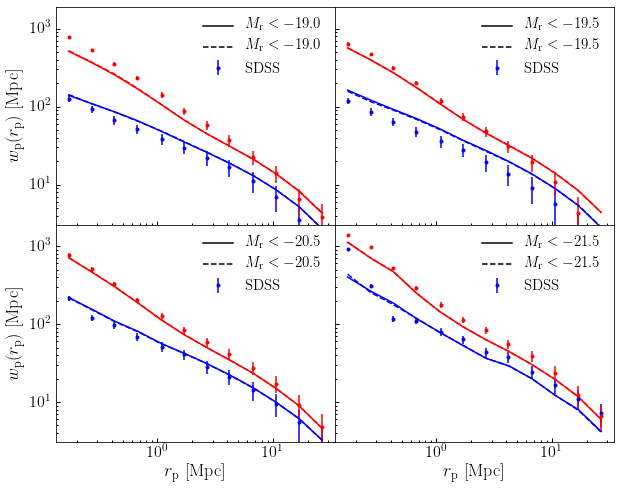

In [73]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

#  Mr < -19.0
__=ax1.errorbar(rp_zehavi, wp_blue19p0, np.sqrt(wperr_blue19p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax1.errorbar(rp_zehavi, wp_red19p0, np.sqrt(wperr_red19p0), 
                fmt='.', color='red')
__=ax1.plot(rp_mids, wp_v4_19p0_blue, color='blue', label=r'$M_{\rm r} < -19.0$')
__=ax1.plot(rp_mids, wp_v4_19p0_red, color='red')

__=ax1.plot(rp_mids, alt_wp_v4_19p0_blue, '--', color='blue', label=r'$M_{\rm r} < -19.0$')
__=ax1.plot(rp_mids, alt_wp_v4_19p0_red, '--', color='red')

#  Mr < -19.5
__=ax2.errorbar(rp_zehavi, wp_blue19p5, np.sqrt(wperr_blue19p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax2.errorbar(rp_zehavi, wp_red19p5, np.sqrt(wperr_red19p5), 
                fmt='.', color='red')
__=ax2.plot(rp_mids, wp_v4_19p5_blue, color='blue', label=r'$M_{\rm r} < -19.5$')
__=ax2.plot(rp_mids, wp_v4_19p5_red, color='red')

__=ax2.plot(rp_mids, alt_wp_v4_19p5_blue, '--', color='blue', label=r'$M_{\rm r} < -19.5$')
__=ax2.plot(rp_mids, alt_wp_v4_19p5_red, '--', color='red')


#  Mr < -20.5
__=ax3.errorbar(rp_zehavi, wp_blue20p5, np.sqrt(wperr_blue20p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax3.errorbar(rp_zehavi, wp_red20p5, np.sqrt(wperr_red20p5), 
                fmt='.', color='red')
__=ax3.plot(rp_mids, wp_v4_20p5_blue, color='blue', label=r'$M_{\rm r} < -20.5$')
__=ax3.plot(rp_mids, wp_v4_20p5_red, color='red')

__=ax3.plot(rp_mids, alt_wp_v4_20p5_blue, '--', color='blue', label=r'$M_{\rm r} < -20.5$')
__=ax3.plot(rp_mids, alt_wp_v4_20p5_red, '--', color='red')

#  Mr < -21.5
__=ax4.errorbar(rp_zehavi, wp_blue21p5, np.sqrt(wperr_blue21p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax4.errorbar(rp_zehavi, wp_red21p5, np.sqrt(wperr_red21p5), 
                fmt='.', color='red')
__=ax4.plot(rp_mids, wp_v4_21p5_blue, color='blue', label=r'$M_{\rm r} < -21.5$')
__=ax4.plot(rp_mids, wp_v4_21p5_red, color='red')

__=ax4.plot(rp_mids, alt_wp_v4_21p5_blue, '--', color='blue', label=r'$M_{\rm r} < -21.5$')
__=ax4.plot(rp_mids, alt_wp_v4_21p5_red, '--', color='red')


xlabel3 = ax3.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')
xlabel4 = ax4.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')

ylabel1 = ax1.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')

for ax in axes:
    leg = ax.legend()
    leg.legendHandles[0].set_color('k')
    leg.legendHandles[1].set_color('k')
    


In [74]:
alt_wp_v4_19p5_red/wp_v4_19p5_red

array([1.00925028, 1.00093716, 1.00555926, 1.00931244, 1.00746599,
       1.00533863, 1.00693651, 1.00983614, 1.00404359, 1.00674448,
       0.99789036, 0.98942411])